In [1]:
# Imports, always include this at the beginning

# No science without NumPy
import numpy as np

# Matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib notebook

# for pretty printing the model
from IPython.display import display, Markdown

# Of course we want Glotaran
import glotaran as gta

In [2]:
# Load the data
dataset_PAL_closed = gta.io.TimeExplicitFile("data/PAL_DCMU_80uM_WL_SF_700_ma_tr2_gain50_100uW_590nmfilter_21C_400nm_AV_bc_sh_sel_620_830.ascii").read("PALclosed")
data_PAL_closed = dataset_PAL_closed.get()
time_axis_PAL_closed = dataset_PAL_closed.get_time_axis()
spectral_axis_PAL_closed = dataset_PAL_closed.get_spectral_axis()

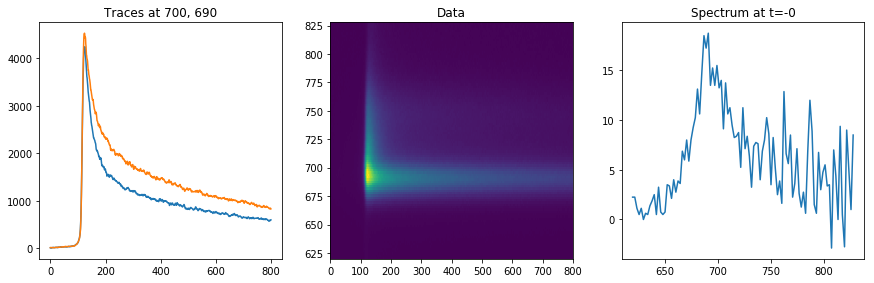

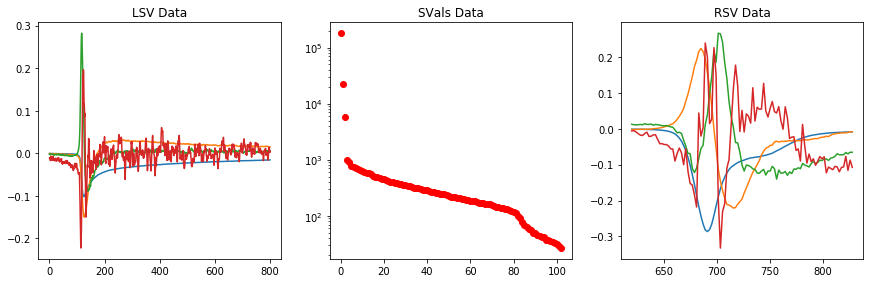

In [3]:
# Plot the Data

plt.figure(figsize=(20, 20))

# Plot some time traces
plt.subplot(4, 4, 1)
wl = [700, 690]
plt.title(f'Traces at {wl[0]}, {wl[1]}')
for w in wl:
    i = (np.abs(spectral_axis_PAL_closed-w)).argmin()
    plt.plot(time_axis_PAL_closed, data_PAL_closed[i, :])

# Full Data
plt.subplot(4, 4, 2)
plt.title('Data')
plt.pcolormesh(time_axis_PAL_closed, spectral_axis_PAL_closed, data_PAL_closed)

# Plot the spectrum at time=0
time_zero = 0
time_zero_idx = (np.abs(time_axis_PAL_closed-time_zero)).argmin()
plt.subplot(4, 4, 3)
plt.title(f'Spectrum at t=-{time_zero}')
plt.plot(spectral_axis_PAL_closed, data_PAL_closed[:, time_zero_idx])


plt.figure(figsize=(20, 20))

lsvd, svals, rsvd = dataset_PAL_closed.svd()

# Plot left singular vectors (LSV, times, first 4)
plt.subplot(4, 4, 1)
plt.title('LSV Data')
for i in range(4):
    plt.plot(time_axis_PAL_closed, lsvd[:, i])

# Plot singular values (SV)
plt.subplot(4, 4, 2)
plt.title('SVals Data')
plt.plot(range(max(10, min(len(time_axis_PAL_closed), len(spectral_axis_PAL_closed)))), svals, 'ro')
plt.yscale('log')

# Plot right singular vectors (RSV, wavelengths, first 4)
plt.subplot(4, 4, 3)
plt.title('RSV Data')
for i in range(4):
    plt.plot(spectral_axis_PAL_closed, rsvd[:, i])

In [9]:
# Then we can create our model

model_spec = '''
type: kinetic
parameters: 
  - initial_concentration:
    - ["0", 1, {vary: false}]
    - ["1", 0, {vary: false}]
  - irf:
    - ["center", 110]
    - ["width", 4.5]
  - k:
    - 0.08
    - 0.03
    - 0.001

      
compartments: [s2, s3, s4]

megacomplexes:
    - label: mc1
      k_matrices: [km1]
      
k_matrices:
  - label: "km1"
    matrix: {
      '("s3","s2")': k.1,
      '("s4","s3")': k.2,
      '("s4","s4")': k.3
    }
    
irf:
  - label: irf
    type: gaussian
    center: irf.center
    width: irf.width

initial_concentration: #equal to the total number of compartments
  - label: inputD1
    parameter: [initial_concentration.1, initial_concentration.0, initial_concentration.0] 
    
datasets:
  - label: PALclosed
    type: spectral
    initial_concentration: inputD1
    megacomplexes: [mc1]
    irf: irf
'''

model = gta.parse(model_spec)
model.set_dataset("PALclosed", dataset_PAL_closed)
# print(model)
display(Markdown(str(model)))

# Model

_Type_: Kinetic

## Parameter
  * __initial_concentration__:
    * __0__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
    * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: 110.0, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 4.5, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
  * __k__:
    * __1__: _Value_: 0.08, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.03, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.001, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True


## Datasets

### _PALclosed_

* _Dataset Scaling_: None
* _Initial Concentration_: inputD1
* _Megacomplexes_: ['mc1']
* _Megacomplex Scalings_: None
* _Irf_: irf

## Compartments

* s2
* s3
* s4

## Megacomplexes

### _mc1_
* _K-Matrices_: ['km1']


## Initital Concentrations

* __inputD1__: ['initial_concentration.1', 'initial_concentration.0', 'initial_concentration.0']

## K-Matrices

### _km1_

compartment |    __s2__ |    __s3__ |    __s4__ |
------------|-----------|-----------|-----------|
     __s2__ |           |           |           |
     __s3__ |       k.1 |           |           |
     __s4__ |           |       k.2 |       k.3 |

## IRFs

### _irf_
* _Type_: 'Gaussian'
* _Center_: ['irf.center']
* _Width_: ['irf.width']
* _Center Dispersion_: []
* _Width Dispersion_: []
* _Scale_: []
* _Nomalize_: True



In [10]:
result = model.fit()
display(Markdown(str(result)))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8088e+08                                    1.29e+11    
       1              2         1.7987e+08      1.01e+06       5.98e+00       1.06e+11    
       2              3         3.3247e+07      1.47e+08       1.50e+00       4.87e+10    
       3              4         2.2425e+07      1.08e+07       8.78e-01       1.95e+09    
       4              5         1.9965e+07      2.46e+06       1.11e-01       6.17e+09    
       5              6         1.8199e+07      1.77e+06       9.23e-02       2.79e+09    
       6              7         1.7539e+07      6.59e+05       1.19e-01       1.16e+09    
       7              8         1.7389e+07      1.50e+05       8.80e-02       3.58e+08    
       8              9         1.7371e+07      1.86e+04       4.08e-02       6.87e+07    
       9             10         1.7369e+07      1.16e+03       1.27e-02       1.00e+07    

# Fitresult

Optimization Result            |            |
-------------------------------|------------|
 Number of residual evaluation |         16 |
           Number of variables |          5 |
          Number of datapoints |     105472 |
            Negrees of freedom |     105467 |
                    Chi Square |34738732.632837 |
            Reduced Chi Square | 329.380115 |

## Best Fit Parameter

  * __initial__:
    * __concentration__:
      * __0__: _Value_: 0.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
      * __1__: _Value_: 1.0, _Min_: -inf, _Max_: inf, _Vary_: False, _Fit_: True
  * __irf__:
    * __center__: _Value_: 116.60263009444459, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __width__: _Value_: 4.797367686959777, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
  * __k__:
    * __1__: _Value_: 0.4481475869300805, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __2__: _Value_: 0.03085470847304015, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True
    * __3__: _Value_: 0.0015189798372699118, _Min_: -inf, _Max_: inf, _Vary_: True, _Fit_: True

